Exploratory Data Analysis 

Import Packages

In [16]:
from ast import literal_eval
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from plotly.figure_factory import create_dendrogram
import plotly.graph_objects as go

Import Data

In [17]:
df = pd.read_excel("albums_final.xlsx")

Clean Data

In [18]:
# drop all rows that don't have genres
df.dropna(subset=["genres"], axis=0, inplace=True)


# convert genres to list
df["genres"] = df["genres"].apply(literal_eval)

Unique Genres
- check how many unique genres there in the data as well as the most popular genres

In [19]:
genres = df["genres"].to_list()
flat_genres = np.hstack(genres)
len(np.unique(flat_genres))
genre_df = pd.DataFrame(flat_genres, columns=["genre"])

Top Genres
- visualize the most common genres
- Singer-songwriter is one of the most common, making up ~7% of the top albums

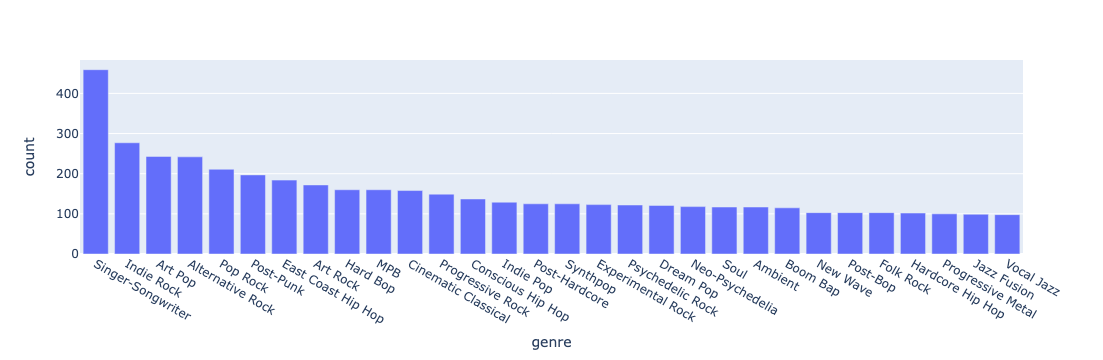

In [20]:
top_genres = pd.DataFrame(genre_df.value_counts()).reset_index()
px.bar(top_genres.head(30), x="genre", y="count")

Co_occurence dictionary
- Co_occurence dictionary of all genres to see wich are seen most often with eachother 

In [21]:
# Initialize a dictionary to store genre pairs and counts
genre_counts = {}


# Iterate through each row
for genres_list in df["genres"]:
    # Generate all pairs of genres
    pairs = combinations(genres_list, 2)
    for pair in pairs:
        # Update the counts
        genre_counts.setdefault(tuple(sorted(pair)), 0)
        genre_counts[tuple(sorted(pair))] += 1

filtered_genres = {key: value for key, value in genre_counts.items() if value > 20}
# sorted_filtered_genres = dict(sorted(filtered_genres.items(), key=lambda item: item[1]))

# Create a DataFrame from the dictionary
co_occurrence_df = pd.DataFrame(
    filtered_genres.values(),
    index=pd.MultiIndex.from_tuples(filtered_genres.keys()),
    columns=["Count"],
)
# print(co_occurrence_df.sort_values("Count", ascending=False))

Co-occurences heat map

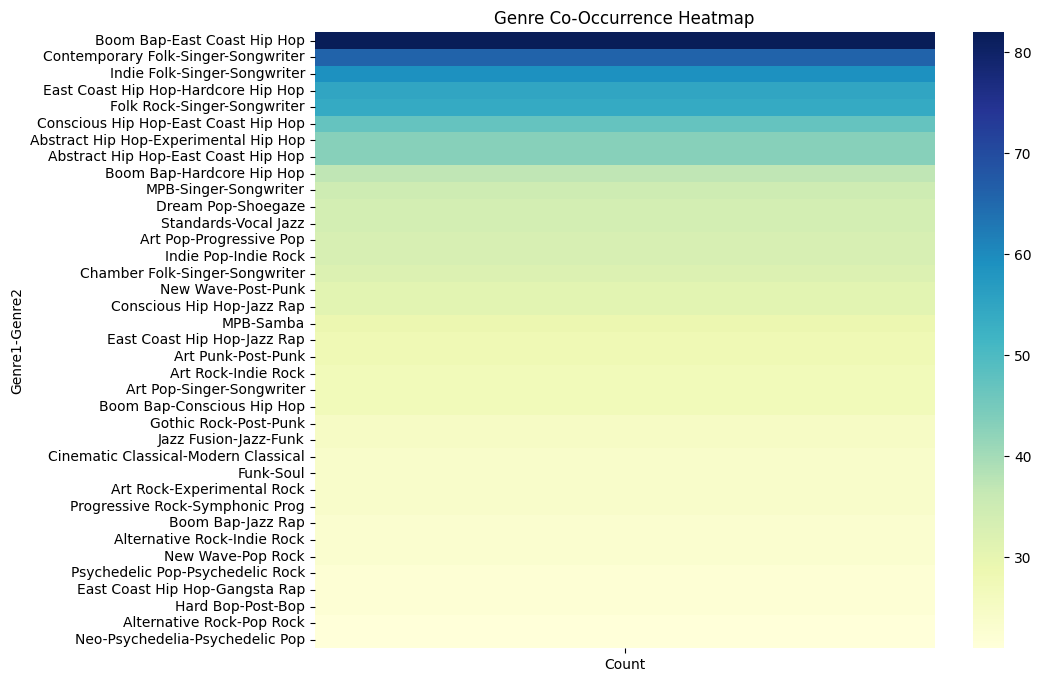

In [22]:
# Create a heatmap to visualize the occurences not as a pivot table
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_df.sort_values("Count", ascending=False), annot=False, cmap="YlGnBu")
plt.title("Genre Co-Occurrence Heatmap")
plt.ylabel("Genre1-Genre2")
plt.show()

Pivot Table and Heatmap of co-occurence matrix

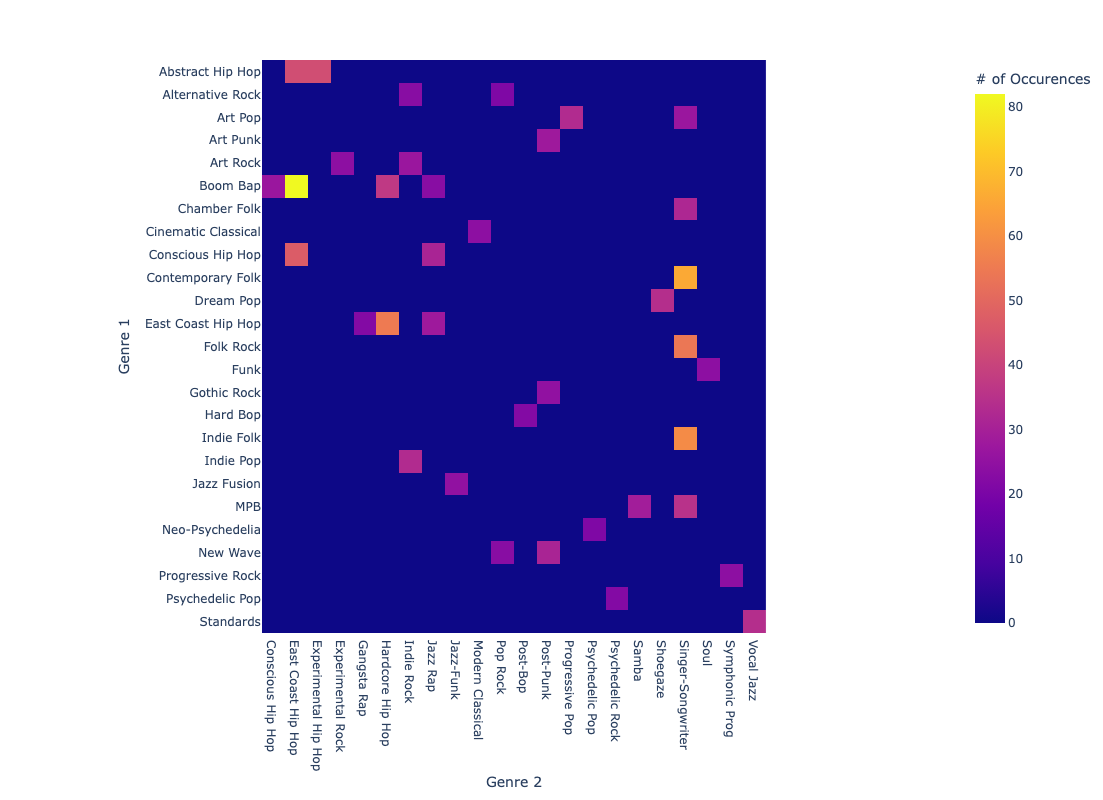

In [23]:
pivot_table = pd.pivot_table(
    co_occurrence_df.reset_index(),
    values="Count",
    index="level_0",
    columns="level_1",
    fill_value=0,
)


# Visualize Pivot Table
px.imshow(
    pivot_table,
    labels=dict(
        x="Genre 2",
        y="Genre 1",
        color="# of Occurences",
    ),
    width=800,
    height=800,
)

In [24]:
# Scatter plot of the genre occurences, not a great way to represent the data 
# px.scatter(co_occurrence_df.reset_index(), size="Count", x="level_0", y="level_1", labels=dict(level_0="Genre 1", level_1="Genre 2"))

Co-occurence matrix but have the same genres on each axis

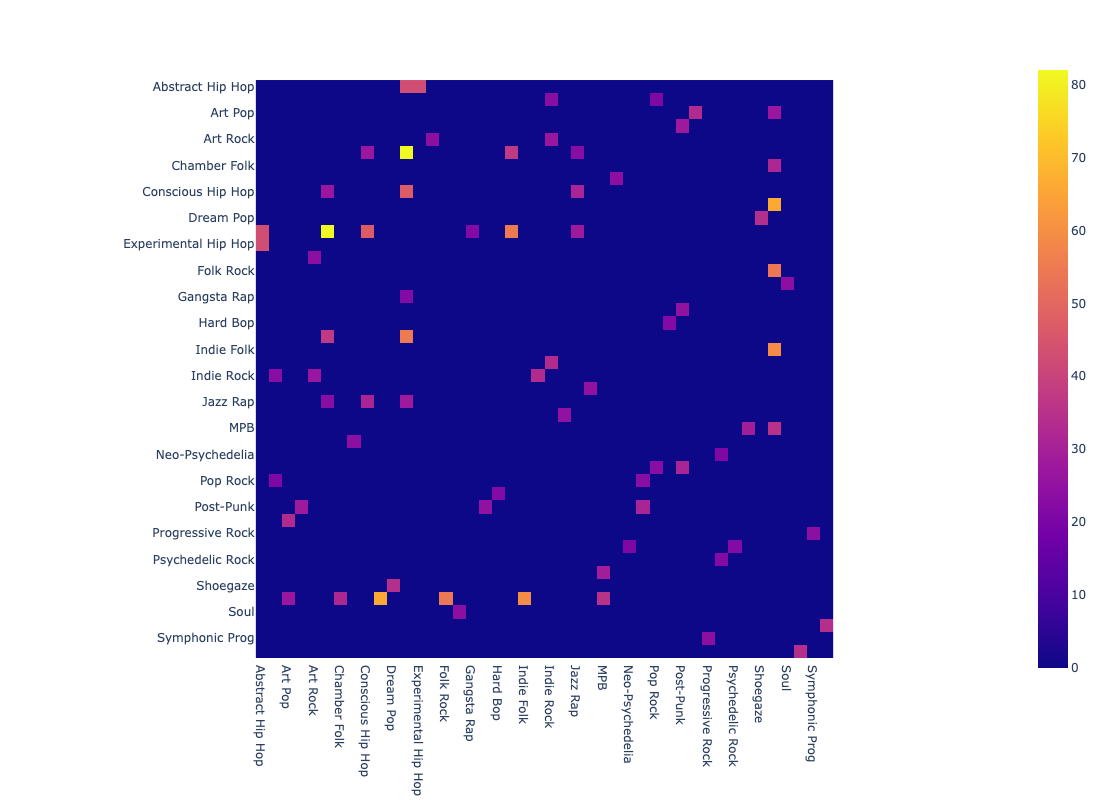

In [25]:
all_genres = set(genre for pair in filtered_genres.keys() for genre in pair)

# Initialize an empty matrix (2D list)
num_genres = len(all_genres)
co_occurrence_matrix = [[0] * num_genres for _ in range(num_genres)]

# Fill in the matrix
genre_to_index = {genre: i for i, genre in enumerate(all_genres)}
for (genre1, genre2), count in filtered_genres.items():
    row, col = genre_to_index[genre1], genre_to_index[genre2]
    co_occurrence_matrix[row][col] = count
    co_occurrence_matrix[col][row] = count  # Symmetric matrix

# Convert to DataFrame (optional)
df_co_occurrence = pd.DataFrame(
    co_occurrence_matrix, index=list(all_genres), columns=list(all_genres)
)
# sort the columns alphabetically 
df_co_occurrence = df_co_occurrence.reindex(sorted(df_co_occurrence.columns), axis=1)


# print(df_co_occurrence)
px.imshow(
    df_co_occurrence.sort_index(), # sort the index alphabetically 
    width=800,
    height=800,
)

Agglomerative Clustering to place the genres into groups so they are more manageable

In [26]:
# Perform hierarchical clustering
n_clusters = 10
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
cluster_labels = clustering.fit_predict(df_co_occurrence)

# Create genre groups based on cluster labels
genre_groups = {i: [] for i in range(n_clusters)}
for genre, label in zip(df_co_occurrence.columns, cluster_labels):
    genre_groups[label].append(genre)
print(genre_groups)

{0: ['Gothic Rock', 'Indie Folk', 'Jazz Fusion', 'Singer-Songwriter'], 1: ['Alternative Rock', 'Art Punk', 'Art Rock', 'Boom Bap', 'Conscious Hip Hop', 'East Coast Hip Hop', 'Experimental Hip Hop', 'Folk Rock', 'Hard Bop', 'Hardcore Hip Hop', 'Indie Pop', 'Indie Rock', 'Modern Classical', 'Neo-Psychedelia', 'Post-Punk', 'Progressive Pop', 'Psychedelic Pop', 'Psychedelic Rock', 'Samba', 'Shoegaze', 'Standards', 'Symphonic Prog', 'Vocal Jazz'], 2: ['Cinematic Classical', 'Dream Pop', 'MPB'], 3: ['Contemporary Folk', 'Experimental Rock', 'Funk', 'Pop Rock', 'Progressive Rock', 'Soul'], 4: ['Jazz-Funk'], 5: ['Chamber Folk'], 6: ['New Wave'], 7: ['Abstract Hip Hop', 'Art Pop', 'Post-Bop'], 8: ['Jazz Rap'], 9: ['Gangsta Rap']}


The genres aren't really grouped as similarly as I think they should be so I will use AOTY's groupings for the genres instead.

Create some functions to explore and compare different genres

In [27]:
def get_genre_df(genre):
    return df[df["genres"].apply(lambda x: genre in x)]

def genre_total(genre):
    return len(get_genre_df(genre).index)
    
def get_genre_top_common_genres(genre, threshold=10, start_year=1955, end_year=2024):
    df = get_genre_df(genre)
    genre_filtered_df = df[
        (df["list_year"] >= start_year) & (df["list_year"] <= end_year)
    ]
    genres = genre_filtered_df["genres"].to_list()
    flat_genres = np.hstack(genres)
    genre_df = pd.DataFrame(flat_genres, columns=["genre"])
    top_genres = pd.DataFrame(genre_df.value_counts()).reset_index()
    return top_genres[1 : threshold + 1]


def compare_genres_occurences(*args, threshold=10, start_year=1955, end_year=2024):
    top_1 = get_genre_top_common_genres(args[0], threshold, start_year, end_year)
    num_of_genres = len(args)
    fig, axs = plt.subplots(ncols=num_of_genres, figsize=(num_of_genres * 5, 6))

    # Plot the heatmap for genre1
    sns.heatmap(
        top_1.set_index("genre"),
        cmap="YlGnBu",
        annot=True,
        fmt="d",
        cbar=True,
        ax=axs[0],
    )
    axs[0].set_title(f"{args[0]} co-occurence genres")
    axs[0].set_xlabel("")
    axs[0].set_ylabel("Genre")

    # Plot the heatmap for genre2
    for idx, genre in enumerate(args[1:]):
        top_2 = get_genre_top_common_genres(genre, threshold, start_year, end_year)
        sns.heatmap(
            top_2.set_index("genre"),
            cmap="YlGnBu",
            annot=True,
            fmt="d",
            cbar=True,
            ax=axs[idx + 1],
        )
        axs[idx + 1].set_title(f"{genre} co-occurence genres")
        axs[idx + 1].set_xlabel("")
        axs[idx + 1].set_ylabel("")

    plt.tight_layout()
    plt.show()


In [28]:
genre1 = "East Coast Hip Hop"
genre2 = "West Coast Hip Hop"
print(f"{genre1} has {genre_total(genre1)} top albums")
print(f"{genre2} has {genre_total(genre2)} top albums")

East Coast Hip Hop has 184 top albums
West Coast Hip Hop has 63 top albums


- East Coast Hip Hop has more than double the amount of albums in the top 100s
- Concious Hip Hop is a genre that is seen often with both Coasts
- East coast has much higher hardcore hip hop while West coast has much higher gangsta rap

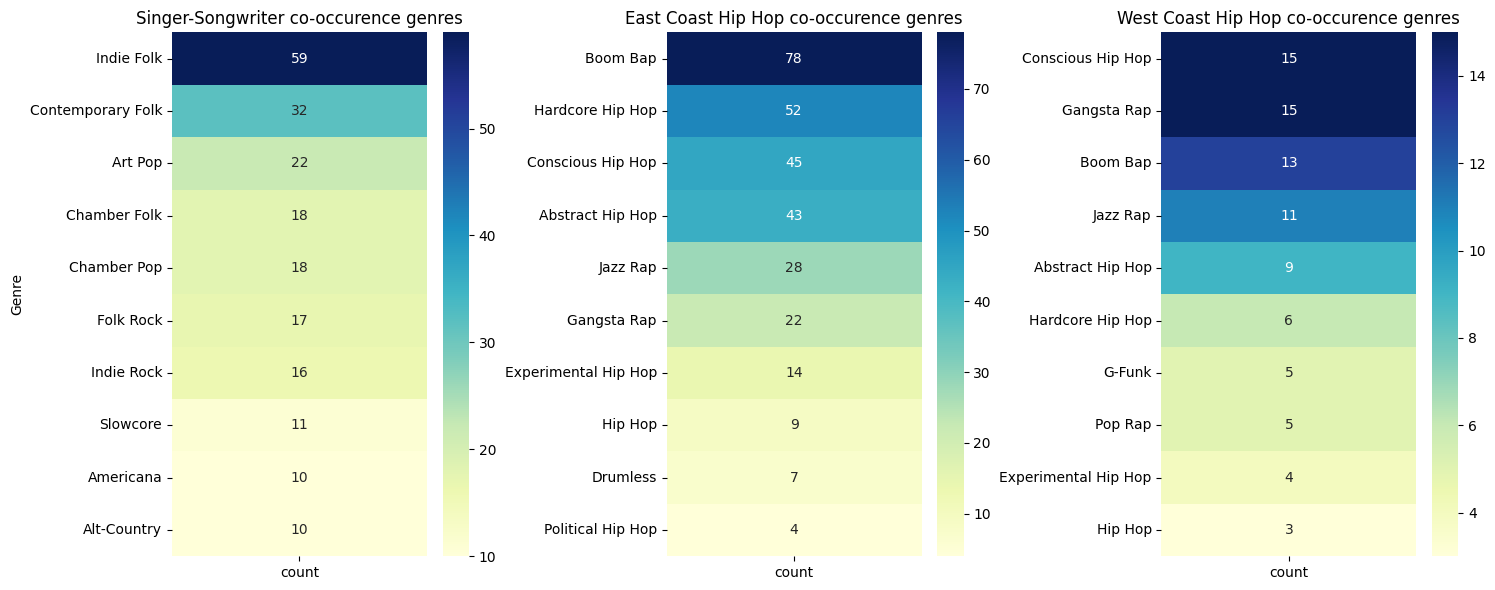

In [29]:
compare_genres_occurences("Singer-Songwriter", "East Coast Hip Hop", "West Coast Hip Hop", threshold=10, start_year=1990)

Compare Number of Releases per Year By Genre Type

In [30]:
def genre_releases_by_year(genre, start_year=1955, end_year=2024):
    genre_df = get_genre_df(genre)
    genre_filtered_df = genre_df[(genre_df['list_year'] >= start_year) & (genre_df['list_year'] <= end_year)]
    return genre_filtered_df.groupby('list_year')['album_name'].count()

def compare_genres_releases_by_year(*args, start_year=1955, end_year=2024):

    genre_dfs = []
    for genre in args:
        genre_dfs.append(genre_releases_by_year(genre, start_year, end_year))

    fig_t = go.Figure()

    for genre in args:
        df = genre_releases_by_year(genre, start_year, end_year)
        fig_t.add_scatter(x=df.index, y=df.values, mode='lines', name=genre)
    fig_t.update_layout(
        legend_title_text='Genres',
        legend=dict(x=1, y=1),
        title="Number of Releases by Year per Genre"
    )
    fig_t.show()

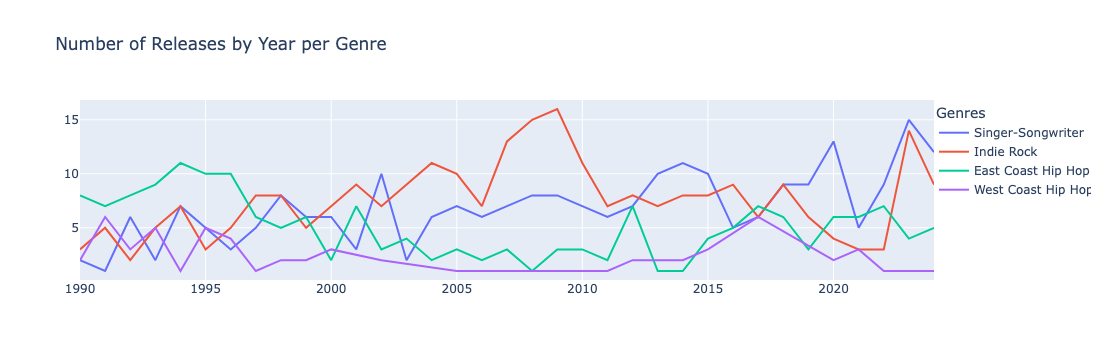

In [33]:
compare_genres_releases_by_year("Singer-Songwriter", "Indie Rock", "East Coast Hip Hop", "West Coast Hip Hop", start_year=1990)

- east and west coast hip hop both follow a similar trend as they decrease in the Noughties (2000s) then pick up again in the teens (2010s)
- Singer-Songwriter seems to be steadily increasing since the 90s

Primary Genre
- add a column that will represent the primary genre for each album

In [34]:
# add a new column called primary genre, which is the first genre from the list of genres
df["primary_genre"] = df["genres"].apply(lambda x: x[0] if x else None)

Heatmap of album releases per year per genre

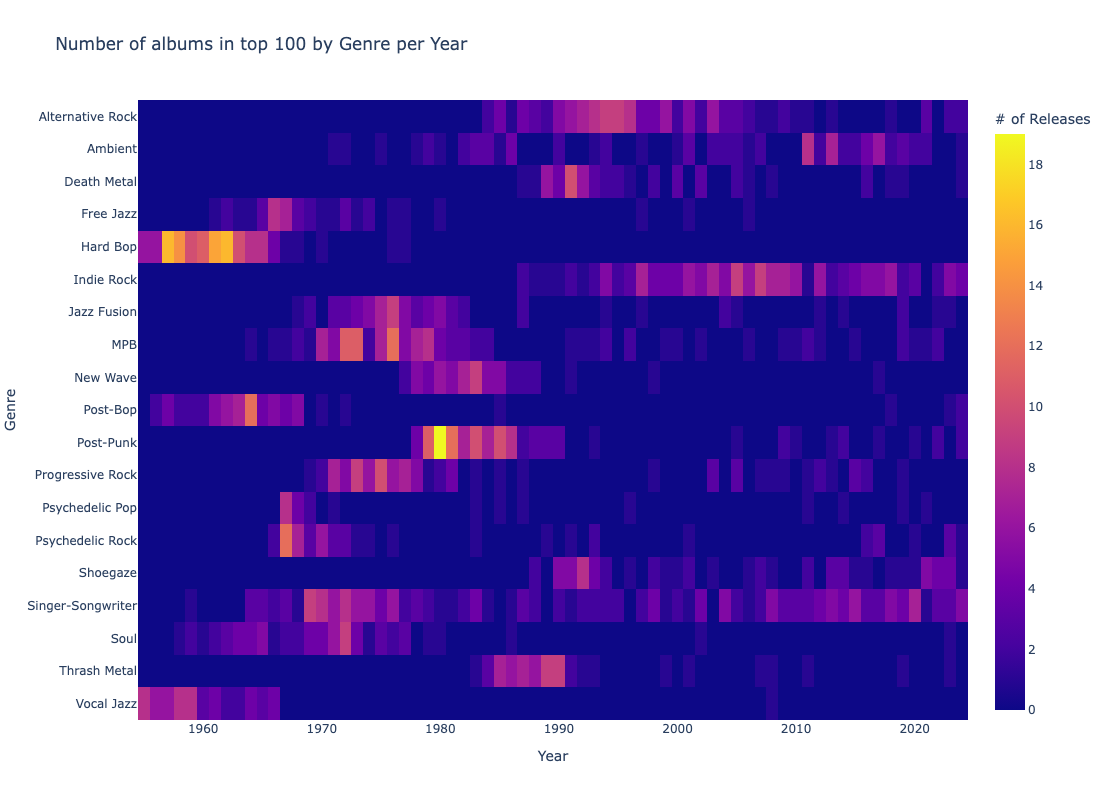

In [43]:
df_grp = df.groupby(["primary_genre", "list_year"], as_index=False).count()[
    ["primary_genre", "list_year", "album_name"]
]

df_pivot = df_grp.pivot(
    index="primary_genre", columns="list_year", values="album_name"
)
# a genre has to have a minimum number of albums make the list in a single year to be shown 
min_albums = 7
df_pivot = df_pivot.loc[df_pivot[df_pivot > min_albums].any(axis=1)]
df_pivot = df_pivot.fillna(0)


px.imshow(
    df_pivot,
    labels=dict(
        x="Year",
        y="Genre",
        color="# of Releases",
    ),
    title="Number of albums in top 100 by Genre per Year",
    height=800,
)

- Looks like singer-songwriter had a lull and is making/made a comeback
- Psychedelic Rock also seems to making a little comeback
- Shoegaze might be on the rise as well

Top primary genres with the most sales

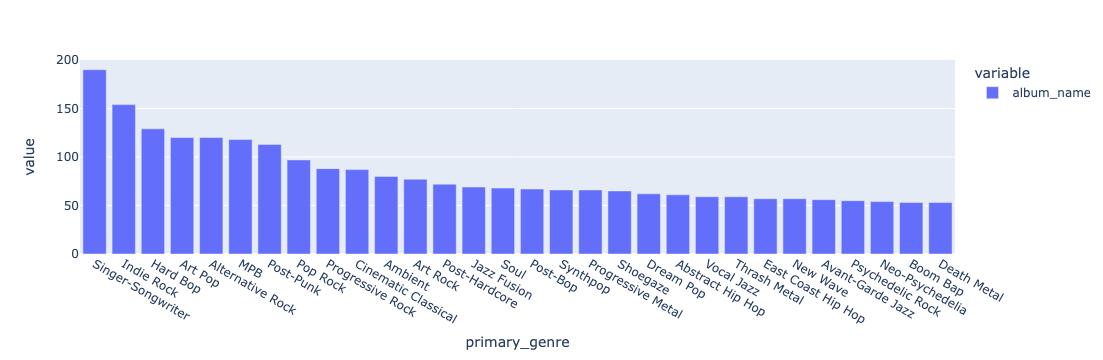

In [42]:
top_genres = df.groupby("primary_genre").count()["album_name"].sort_values(ascending=False)
px.bar(top_genres.head(30))

We'll visualize the top genres with the most sales instead of visualize certain genres that might of had just one good year

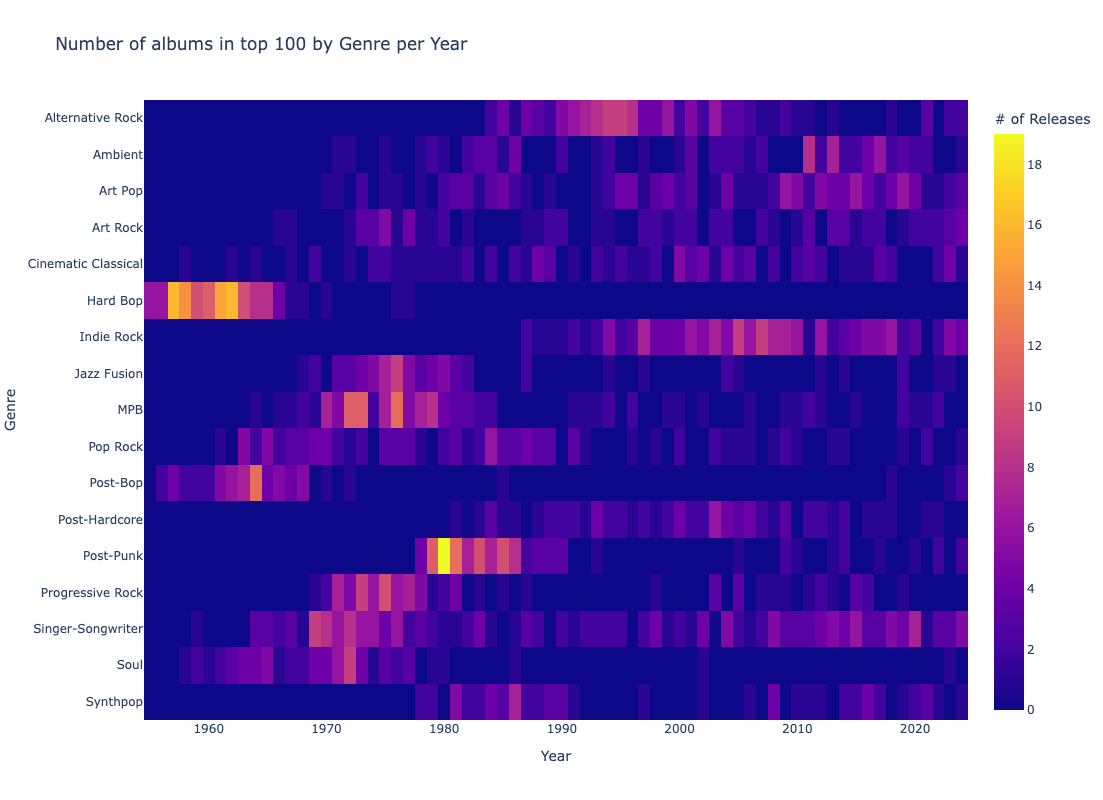

In [46]:
genres_list = top_genres.head(17).index 
df_top_grp = df[df["primary_genre"].isin(genres_list)]
df_grp = df_top_grp.groupby(["primary_genre", "list_year"], as_index=False).count()[
    ["primary_genre", "list_year", "album_name"]
]

df_pivot = df_grp.pivot(
    index="primary_genre", columns="list_year", values="album_name"
)
# a genre has to have a minimum number of albums make the list in a single year to be shown 
min_albums = 0
df_pivot = df_pivot.loc[df_pivot[df_pivot > min_albums].any(axis=1)]
df_pivot = df_pivot.fillna(0)


px.imshow(
    df_pivot,
    labels=dict(
        x="Year",
        y="Genre",
        color="# of Releases",
    ),
    title="Number of albums in top 100 by Genre per Year",
    height=800,
)


- alt rock and post-punk seem to have the best showing of a comeback
- cinematic classical seems to be the most consistent
- soul seems to be due for a revival but new genres like neo-soul and r&b could be already doing that so the data needs to be altered to better visualize 

Gather the top 10 genres of all time and the top 10 genres of the 2020s to see what was popular and what is growing in popularity

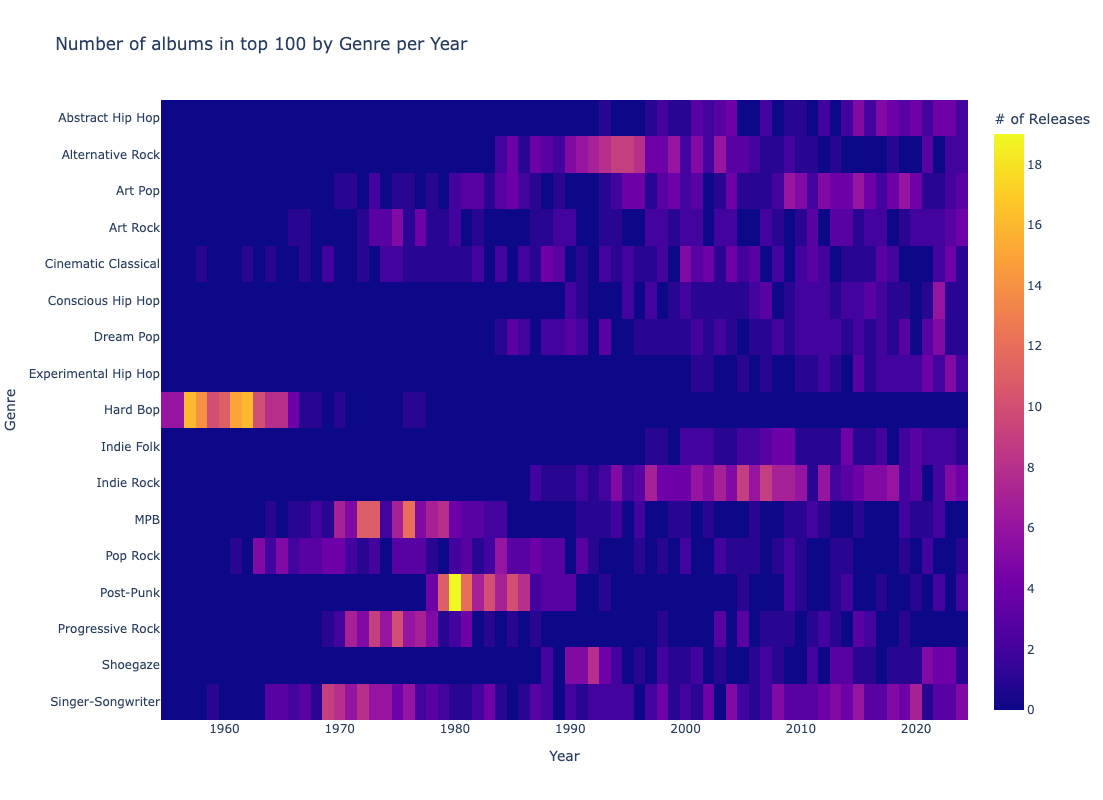

In [47]:
top_genres_2020s = df[df["list_year"] >= 2020]["primary_genre"].value_counts()
num_genres = 10
genres_list = set(top_genres.head(num_genres).index.to_list() + top_genres_2020s.head(num_genres).index.to_list())

df_top_grp = df[df["primary_genre"].isin(genres_list)]
df_grp = df_top_grp.groupby(["primary_genre", "list_year"], as_index=False).count()[
    ["primary_genre", "list_year", "album_name"]
]

df_pivot = df_grp.pivot(index="primary_genre", columns="list_year", values="album_name")
# a genre has to have a minimum number of albums make the list in a single year to be shown
min_albums = 0
df_pivot = df_pivot.loc[df_pivot[df_pivot > min_albums].any(axis=1)]
df_pivot = df_pivot.fillna(0)


px.imshow(
    df_pivot,
    labels=dict(
        x="Year",
        y="Genre",
        color="# of Releases",
    ),
    title="Number of albums in top 100 by Genre per Year",
    height=800,
)